Running a Tobit style regression in Stan.

In [1]:
# set up Python
from typing import Iterable
import logging
import numpy as np
import pandas as pd
from plotnine import *
from cmdstanpy import CmdStanModel

# quiet down Stan
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())

In [2]:
rng = np.random.default_rng(2024)

In [3]:
# from 
# https://win-vector.com/2024/08/16/post-hoc-adjustment-for-zero-thresholded-linear-models/
def trueprocess(mu: float, N: int =1000):
  x = rng.normal(size=N, loc=mu)
  xnoise = x + 0.1 * rng.normal(size=N)
  y = np.maximum(0.0, xnoise)
  df = pd.DataFrame({'x': x, 'y': y})
  return df

traind = trueprocess(mu=0, N=1000)

traind.head()

,x,y
0,1.028857,1.116961
1,1.641920,1.557520
2,1.146720,0.949668
3,-0.973180,0.000000
4,-1.392800,0.000000


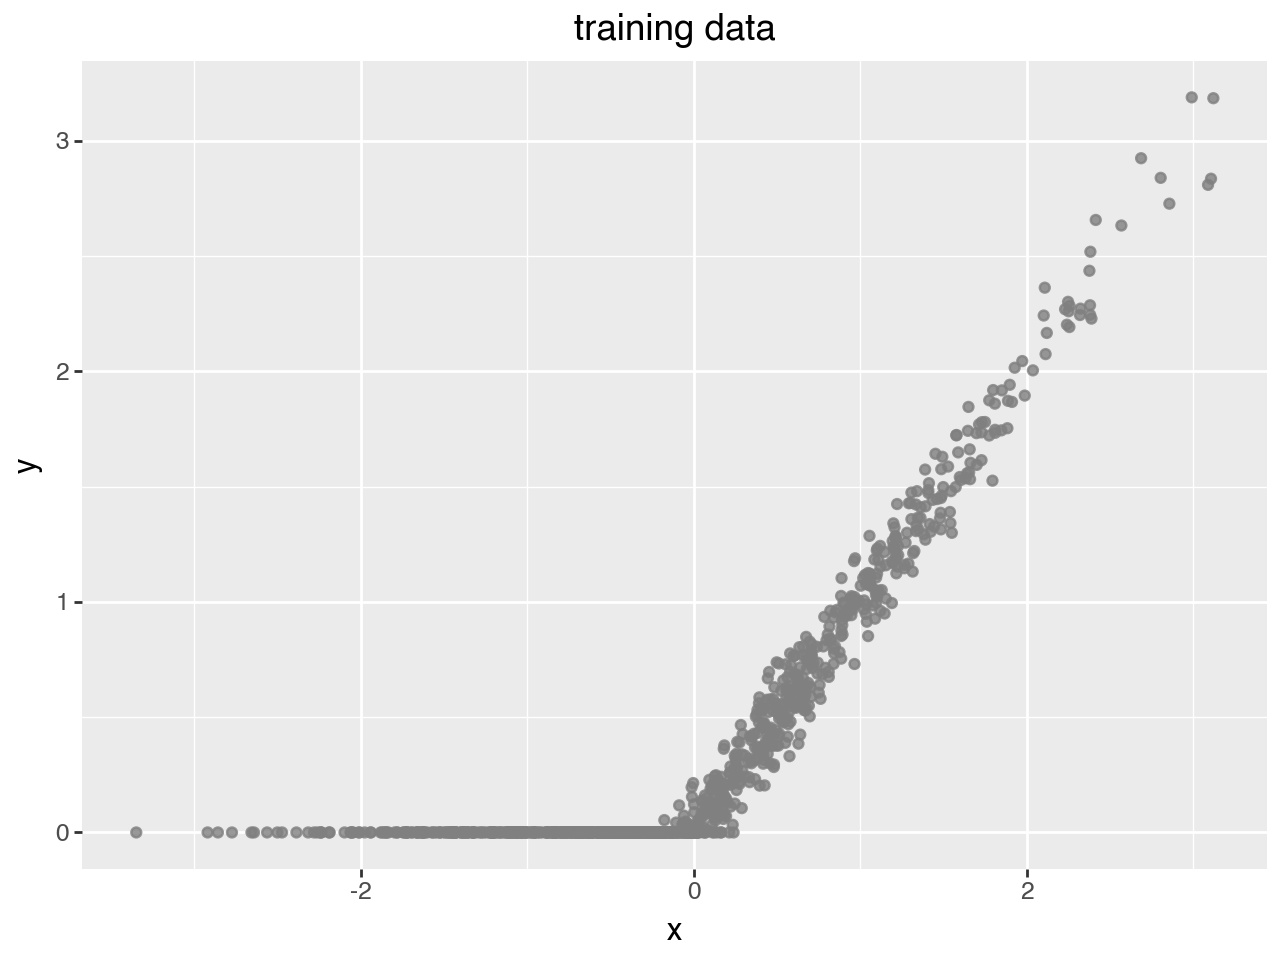

In [4]:
(
    ggplot(
        data=traind, 
        mapping=aes(x='x', y='y')) + 
    geom_point(color="gray", alpha=0.8) + 
    ggtitle("training data")
)

In [5]:
stan_model_src = """
data {
  int<lower=0> N_positive;   // number of positive observations
  int<lower=0> N_zero;       // number of zeros observations
  vector[N_positive] x_pos;  // observed predictions (to be adjusted to match outcomes)
  vector[N_positive] y_pos;  // observed outcomes
  vector[N_zero] x_zero;     // observed predictions (to be adjusted to match outcomes)
}
parameters {
  real a;               // regression slope
  real b;               // regression intercept
  real<lower=0> sigma;  // variance
}
model {
      // basic priors
  a ~ normal(0, 10);
  b ~ normal(0, 10);
  sigma ~ chi_square(1);
      // Tobit style model structure
  y_pos ~ normal(a * x_pos + b, sigma);
  target += normal_lcdf( 0 | a * x_zero + b, sigma);
}
"""

In [6]:
# build model
stan_file = 'tobit_tmp.stan'
with open(stan_file, 'w', encoding='utf8') as file:
    file.write(stan_model_src)
# instantiate the model object
model = CmdStanModel(stan_file=stan_file)

model

CmdStanModel: name=tobit_tmp
	 stan_file=/Users/johnmount/Documents/work/Examples/linear_regression_w_zeros/tobit_tmp.stan
	 exe_file=/Users/johnmount/Documents/work/Examples/linear_regression_w_zeros/tobit_tmp
	 compiler_options=stanc_options={}, cpp_options={}

In [7]:
pos_positions = traind['y'] > 0
x_pos = list(traind['x'][pos_positions])
y_pos = list(traind['y'][pos_positions])
x_zero = list(traind['x'][pos_positions == False])

In [8]:
data_str = f"""
{{
"N_positive" : {len(x_pos)},
"N_zero" : {len(x_zero)},
"x_pos" : {x_pos},
"y_pos" : {y_pos},
"x_zero" : {x_zero}
}}
"""

print(data_str)


{
"N_positive" : 495,
"N_zero" : 505,
"x_pos" : [1.0288568739519013, 1.6419200406711503, 1.1467195295966137, 0.06719635507109722, 0.8613509179404263, 0.509186798845688, 1.8102855742952833, 0.7508434731539183, 0.6397595539314624, 1.4844055856837017, 0.048912403069534136, 0.8115201169815576, 0.9030630777436289, 0.4181385697197018, 0.27226068000682285, 0.05681919548353432, 0.42456925614196805, 0.224943388070294, 1.6576840551979304, 1.1991871656162354, 1.21119446936847, 0.6343009414440183, 0.7782729899588319, 1.8481672953210666, -0.11479794585014706, 0.3941991740101531, 0.761728470454166, 1.335270728748762, 1.2654519785916296, 0.7099782281560677, 0.6029173174380699, 1.1456772338915662, 0.886902071116937, 0.4175846609939748, 0.13974968489353012, 1.9735553403293085, 0.09906791154843822, 0.5382077472406755, 0.6630316327280554, 1.0556415438104036, -0.059613974391862584, 0.7906767161489346, 0.1896104030769387, 0.14500945046766703, 1.2283676805724408, 0.885130796232711, 0.36087808534664895, 0.4

In [9]:
data_file = "tobit_tmp.json"
with open(data_file, 'w', encoding='utf8') as file:
    file.write(data_str)

In [10]:
fit = model.sample(
    data=data_file,
    show_progress=False,
    show_console=False,
    )

In [11]:
res = fit.draws_pd()

In [12]:
res

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a,b,sigma
0,836.081,0.994820,0.503371,2.0,7.0,0.0,-834.882,1.003340,-0.003126,0.105226
1,834.644,0.848659,0.503371,2.0,7.0,0.0,-834.076,0.996153,-0.003150,0.098137
2,834.464,0.684030,0.503371,3.0,7.0,0.0,-831.306,0.995719,-0.002350,0.097689
3,833.562,0.880041,0.503371,3.0,7.0,0.0,-831.596,1.015750,-0.009443,0.101963
4,833.538,1.000000,0.503371,3.0,7.0,0.0,-832.584,1.006010,-0.016165,0.107558
...,...,...,...,...,...,...,...,...,...,...
3995,835.534,0.997977,0.435348,3.0,7.0,0.0,-833.776,1.000650,0.002692,0.104501
3996,836.383,0.956042,0.435348,2.0,7.0,0.0,-833.313,0.999124,-0.001846,0.101809
3997,835.434,0.735688,0.435348,2.0,7.0,0.0,-833.392,1.007050,-0.008218,0.099481
3998,834.185,0.945759,0.435348,2.0,3.0,0.0,-834.074,1.008930,-0.008362,0.097604


In [13]:
a = res['a'].mean()
b = res['b'].mean()

(a, b)

(1.00157206975, -0.0036436502104042496)

In [14]:
traind['prediction'] = np.maximum(0, a * traind['x'] + b)

traind

,x,y,prediction
0,1.028857,1.116961,1.026831
1,1.641920,1.557520,1.640858
2,1.146720,0.949668,1.144879
3,-0.973180,0.000000,0.000000
4,-1.392800,0.000000,0.000000
...,...,...,...
995,-1.086436,0.000000,0.000000
996,-0.508474,0.000000,0.000000
997,0.513753,0.428141,0.510917
998,-0.203761,0.000000,0.000000


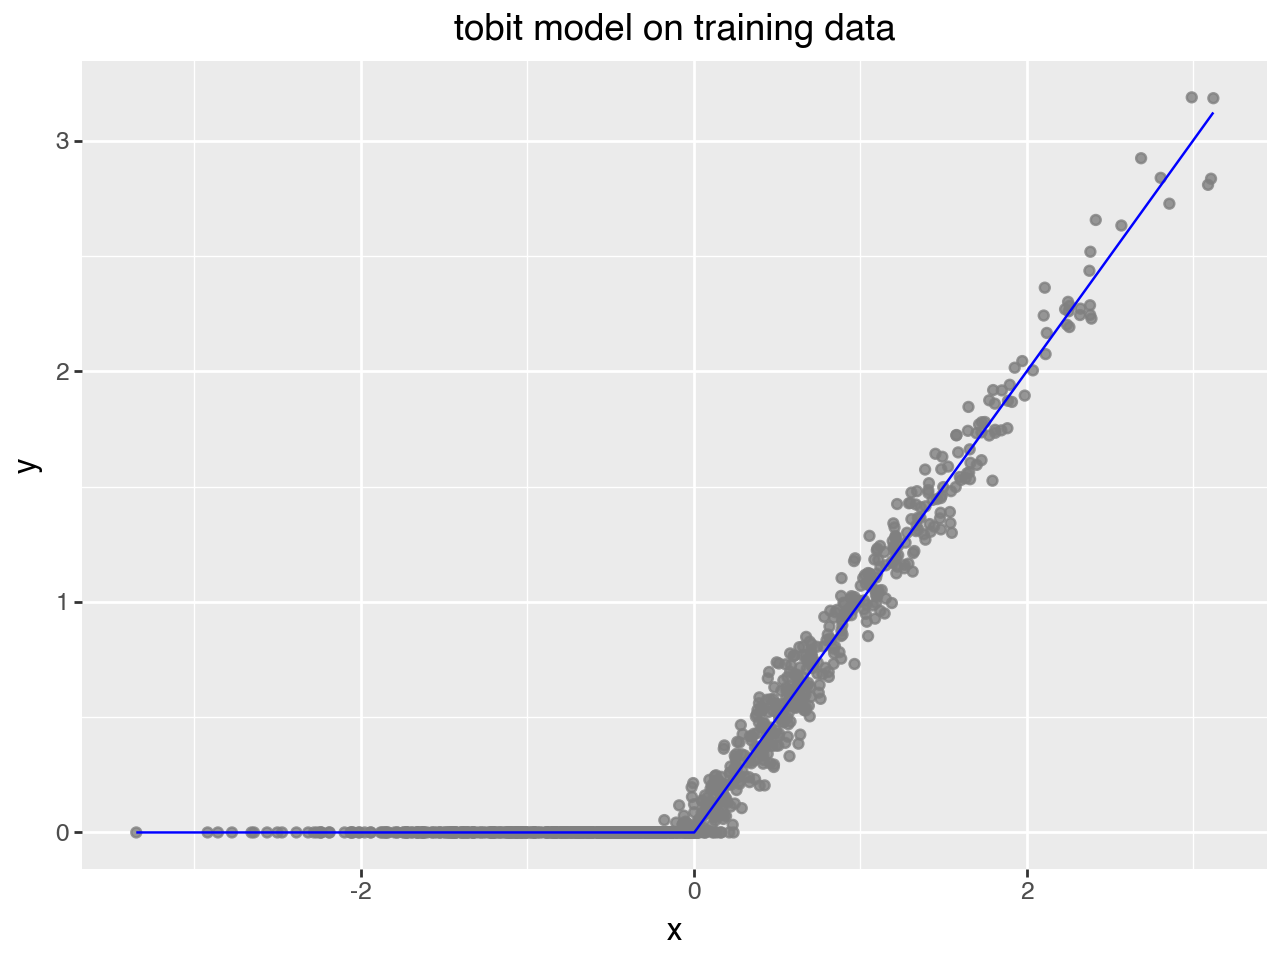

In [15]:
(
    ggplot(
        data=traind, 
        mapping=aes(x='x', y='y')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) +
    geom_line(
        mapping=aes(y='prediction'),
        color="blue") +
    ggtitle("tobit model on training data")
)